In [2]:
"""
My first python programme on https://pythonprogramming.net/
Data Analysis part.
Date : 2017-12-04
"""
import quandl,math
import numpy as np
import pandas as pd

from sklearn import preprocessing,cross_validation,svm
from sklearn.linear_model import LinearRegression

df = quandl.get("WIKI/GOOGL")


D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# print(df.head(10))
# print(df.tail(10))
# print(df.info())
# 注意DataFrame的索引类型是DataTimeIndex ,  而这个索引在info中是显示不出来的
# print(df.index) 
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]

In [4]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low'])/df['Adj. Close']*100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open'])/df['Adj. Open'] * 100.0
df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]

In [5]:
forecast_col='Adj. Close'
df.fillna(value=-99999,inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))

In [6]:
# print(df[forecast_col]) # 这里df[forecast_col]是带着索引的
print(forecast_out) 
# print(df[forecast_col].head(50))
df['label'] = df[forecast_col].shift(-forecast_out) # 移一个月？还是抽样？
# print(df['label'].tail(10))

34


In [7]:
X=np.array(df.drop(['label'],1))
X=preprocessing.scale(X) # 对数据进行标准化 (X-mean)/std
X_lately=X[-forecast_out:]
X=X[:-forecast_out]
df.dropna(inplace=True)
y=np.array(df['label'])
X_train,X_test,y_train,y_test=cross_validation.train_test_split(X,y,test_size=0.2)

In [8]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train,y_train)
confidence=clf.score(X_test,y_test)
print(confidence)

0.973304355475


In [9]:
# 给出预测值
forecast_set=clf.predict(X_lately)
print(forecast_set,confidence,forecast_out) # 到此 我们已经预测出来未来34天的值

[ 1019.6612854   1023.44659581  1001.06074302  1006.15221702  1008.67753478
  1008.19535776  1047.55142579  1050.32185462  1050.68781177  1060.43992569
  1060.6064867   1068.24911274  1060.90540199  1070.88592166  1065.36077136
  1063.21029208  1059.75050291  1059.84962023  1055.03200879  1066.77442758
  1052.8861134   1053.55349097  1068.95915276  1070.78680111  1075.43695883
  1089.90630326  1079.52496055  1052.33647824  1053.5960484   1041.66513964
  1027.77209598  1034.78268297  1049.71157942  1062.73428946] 0.973304355475 34


In [10]:
# 为了更加直观的理解，我们通过画图来看一下
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
df['Forecast']=np.nan # initiate value

In [11]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 24*3600
next_unix=last_unix+one_day
# 把预测值添加到源数据的 dataframe当中
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix+=86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

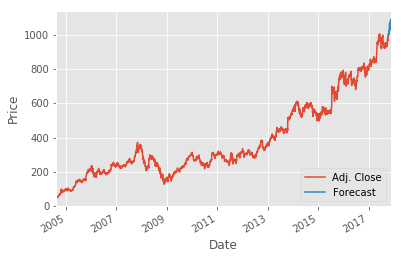

In [12]:
# 开始画图
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [13]:
#####  为了将来将 train test predict 工具化
#####  我们采用pickle工具将该过程存到文件中
import  pickle
with open ('linearregression.pickle','wb') as f :
    pickle.dump(clf,f) # 将对象clf存到本地文件linearregression.pickle中
